## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Аринин Матвей Алексеевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm.auto import tqdm
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(2 балл)**

## Срок выполнения задания:
Софт дедлайн - 8 октября 23:59  
Хард дедлайн - 15 октября 23:59


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
from pathlib import Path

# Предполагается, что YT_PREFIX и output[0].path определены ранее в коде
output_path = "ytTable:/" + str(Path("//home/hc/predict/desc/snb/dyn_interests/v1/clickstream_tier1_daily/") / '2025-09-01')
output_path

'ytTable:/\\\\home\\hc\\predict\\desc\\snb\\dyn_interests\\v1\\clickstream_tier1_daily\\2025-09-01'

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

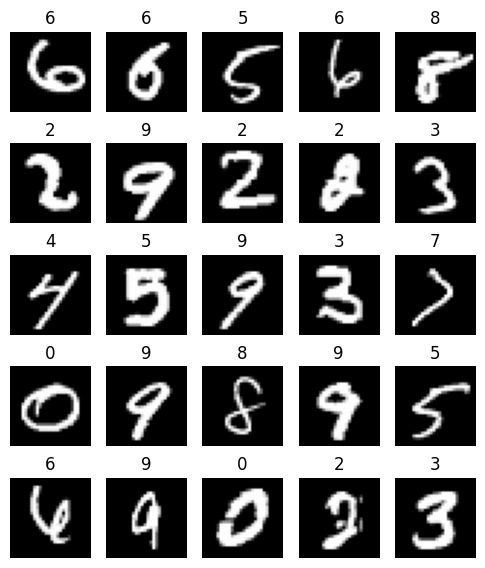

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [7]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [8]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [9]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

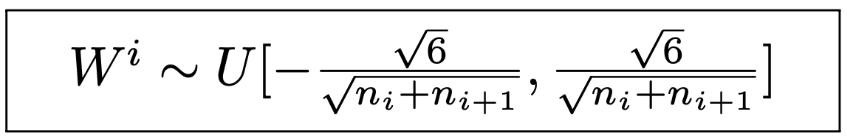

In [10]:
def xavier_init_layer(layer, a_range):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-a_range, a_range)

def xavier(size_input, size_output):
    gain = nn.init.calculate_gain('tanh')
    d = (6 / (size_input + size_output))
    return np.sqrt(d)*gain

In [11]:
def show_loss(network):
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    loss = loss_fn(activations, y)
    loss.backward()

In [12]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

xavier_init_layer(layer_1,xavier(28*28,500))
xavier_init_layer(layer_2,xavier(500,10))

In [13]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)
show_loss(network)

forward 0.9909528493881226
forward 0.7755002379417419
backward 0.04294699430465698
backward 0.01602378487586975


D:\Iterpretators\Python3.11\Lib\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [14]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

In [15]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)
show_loss(network)

forward 0.9909528493881226
forward 16.215402603149414
backward 0.04294699430465698
backward 0.19788651168346405


Результаты показывают, что инициализация He дает лучшие результаты при использовании активации ReLU, обеспечивая более быстрый процесс обучения и меньший лосс. В то же время, при применении функции активации Tanh, инициализация Xavier оказывается более подходящей, так как она помогает избежать проблем с исчезающими и взрывающимися градиентами.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

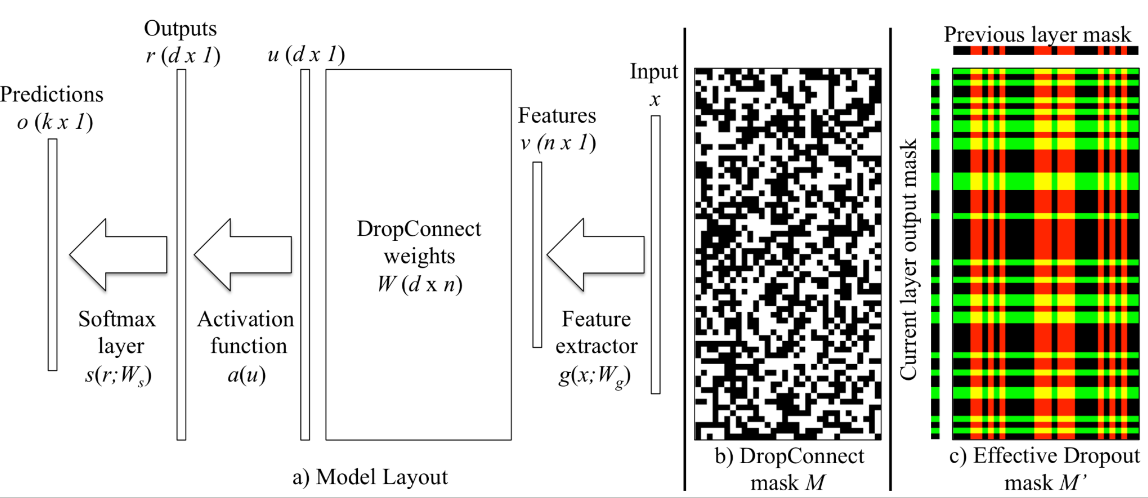

In [16]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros_like(self.linear.weight).bernoulli_(self.p)
        else:
            mask = Variable(torch.zeros_like(self.linear.weight,requires_grad=False) + self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [17]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [18]:
layers = [
    nn.Linear(196,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,10)
]

In [19]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [20]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300003
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.487361
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.198962
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.139157
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.229306
Test Epoch: 0	Loss: 0.131540
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.097797
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.130440
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.068540
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.067899
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.089654
Test Epoch: 1	Loss: 0.102101
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.158872
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.059883
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.060023
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.067334
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.055440
Test Epoch: 2	Loss: 0.068083
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.082994
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.069192
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.046056
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [21]:
def train(net, optimizer, train_loader, val_loader,
           epochs, criterion, plot=True, verbose=True):
    train_loss_epochs, val_loss_epochs = [], []
    train_accuracy_epochs, val_accuracy_epochs = [], []

    n_params = 0
    for p in net.parameters():
        if p.requires_grad:
            n_params = n_params + p.numel()

    for epoch in tqdm(range(epochs)):
        losses = []
        correct = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            out = net(data)
            loss = criterion(out, target)
            losses.append(loss.item())

            pred = out.argmax(1)
            correct += pred.eq(target).sum().item()

            loss.backward()
            optimizer.step()

        train_loss = np.mean(losses)
        train_acc = correct / len(train_loader.dataset)
        train_loss_epochs.append(train_loss)
        train_accuracy_epochs.append(train_acc)

        losses = []
        correct = 0
        for data, target in val_loader:
            out = net(data)
            loss = criterion(out, target)
            losses.append(loss.item())

            pred = out.argmax(1)
            correct += pred.eq(target).sum().item()

        val_loss = np.mean(losses)
        val_acc = correct / len(val_loader.dataset)
        val_loss_epochs.append(val_loss)
        val_accuracy_epochs.append(val_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train: loss={train_loss:.4f} | acc={train_acc:.4f}")
            print(f"  Val  : loss={val_loss:.4f} | acc={val_acc:.4f}")
            print(f"  Trainable params: {n_params}")

        if plot:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(val_loss_epochs, label='Val')
            plt.xlabel('Epochs'); plt.ylabel('Loss')
            plt.legend(); plt.grid(True)
            
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train')
            plt.plot(val_accuracy_epochs, label='Val')
            plt.xlabel('Epochs'); plt.ylabel('Accuracy')
            plt.legend(); plt.grid(True)
            plt.show()
    return {
        "train_loss": train_loss_epochs,
        "val_loss": val_loss_epochs,
        "train_acc": train_accuracy_epochs,
        "val_acc": val_accuracy_epochs,
    }

In [22]:
# 1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
layers = [
    nn.Linear(196,128),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(128,10)
]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.6221 | acc=0.7993
  Val  : loss=0.2594 | acc=0.9160
  Trainable params: 43114


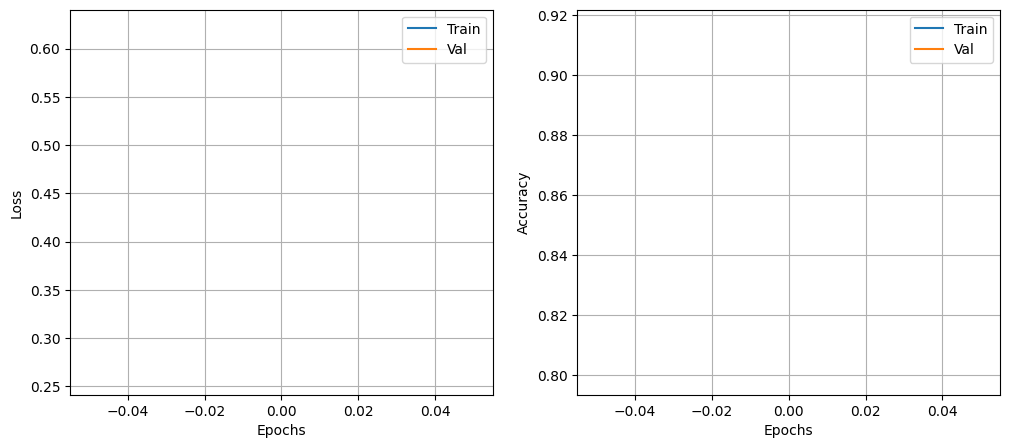

Epoch 2/10
  Train: loss=0.2155 | acc=0.9329
  Val  : loss=0.1915 | acc=0.9403
  Trainable params: 43114


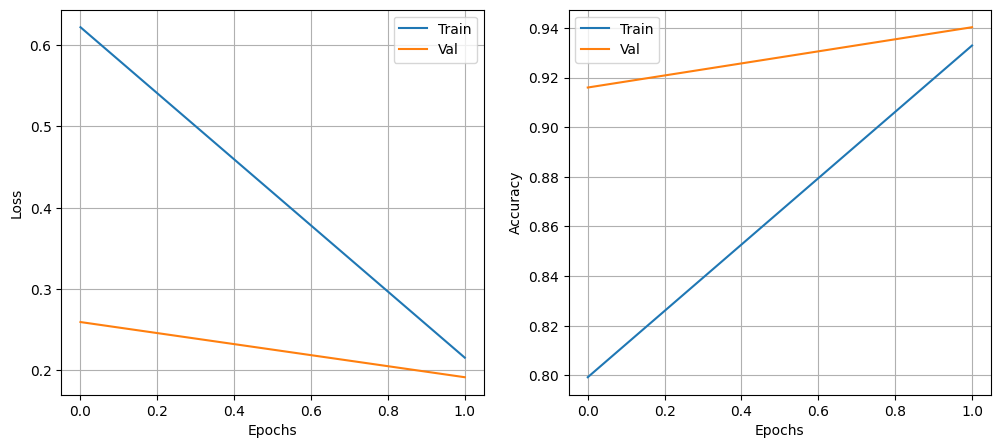

Epoch 3/10
  Train: loss=0.1636 | acc=0.9491
  Val  : loss=0.1446 | acc=0.9561
  Trainable params: 43114


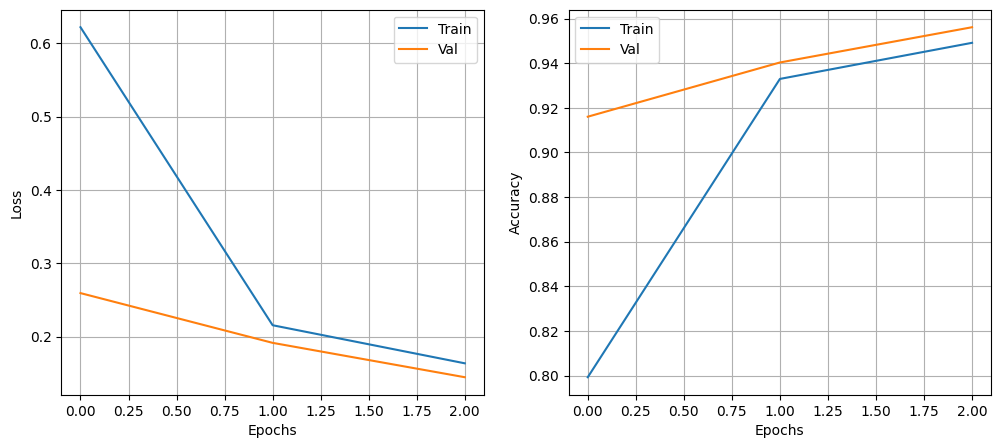

Epoch 4/10
  Train: loss=0.1377 | acc=0.9574
  Val  : loss=0.1321 | acc=0.9593
  Trainable params: 43114


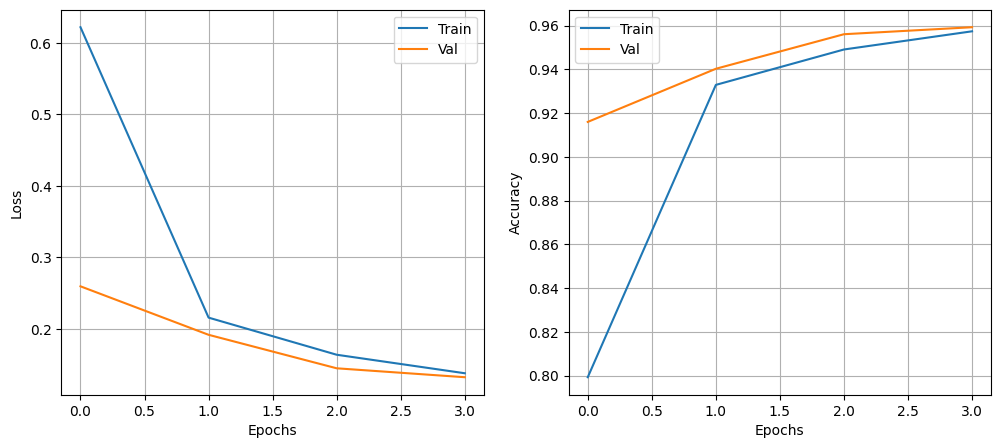

Epoch 5/10
  Train: loss=0.1212 | acc=0.9630
  Val  : loss=0.1150 | acc=0.9644
  Trainable params: 43114


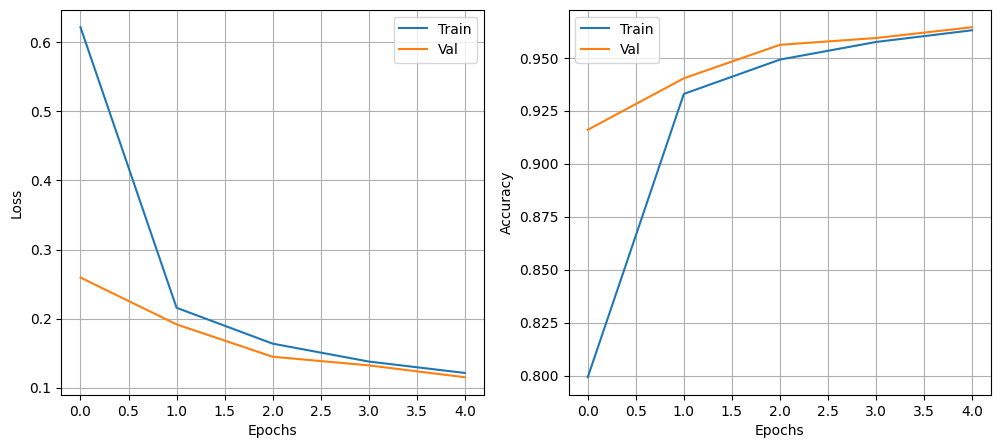

Epoch 6/10
  Train: loss=0.1079 | acc=0.9663
  Val  : loss=0.1175 | acc=0.9639
  Trainable params: 43114


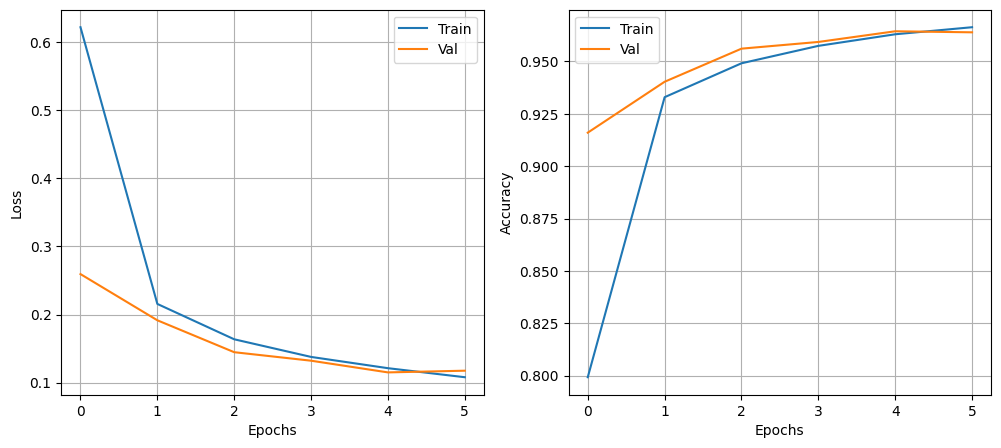

Epoch 7/10
  Train: loss=0.1013 | acc=0.9690
  Val  : loss=0.1013 | acc=0.9691
  Trainable params: 43114


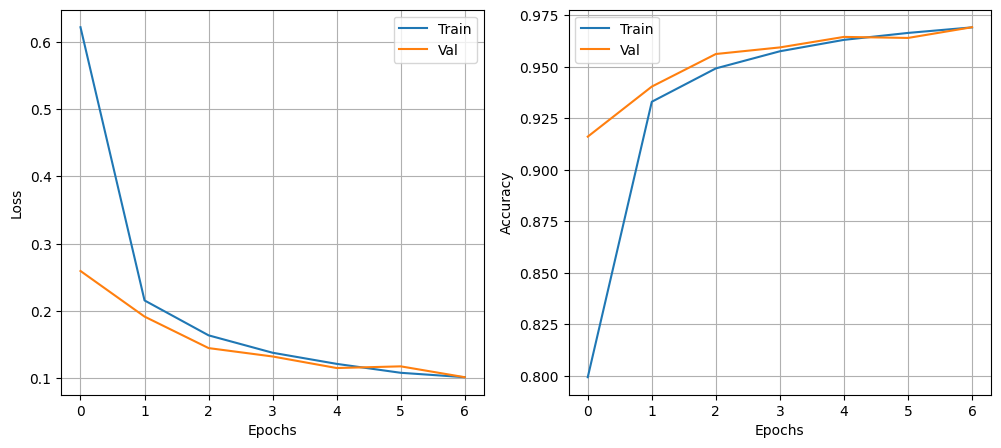

Epoch 8/10
  Train: loss=0.0946 | acc=0.9712
  Val  : loss=0.1004 | acc=0.9702
  Trainable params: 43114


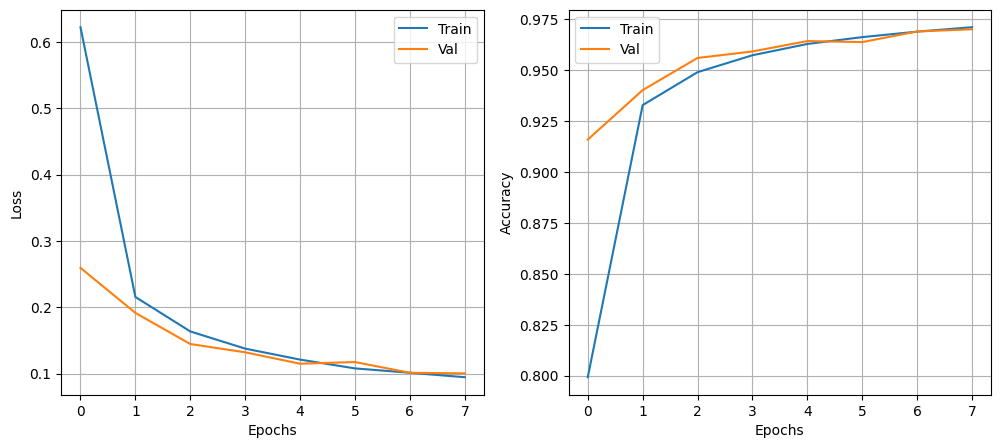

Epoch 9/10
  Train: loss=0.0883 | acc=0.9729
  Val  : loss=0.1055 | acc=0.9681
  Trainable params: 43114


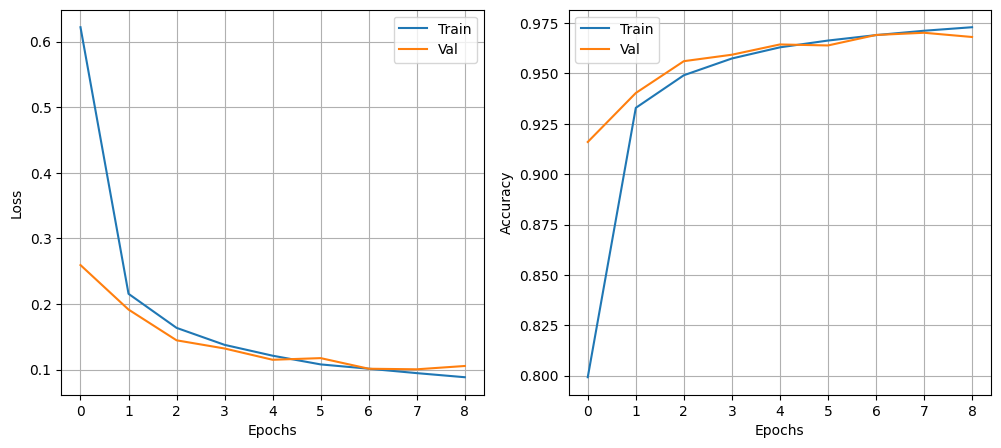

Epoch 10/10
  Train: loss=0.0833 | acc=0.9742
  Val  : loss=0.0980 | acc=0.9703
  Trainable params: 43114


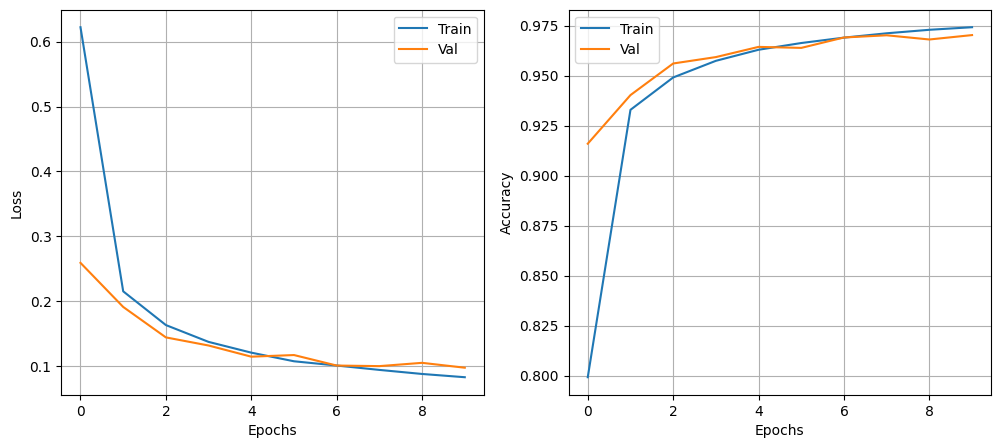

In [23]:
model = TestNetwork(nn.Sequential(*layers))
dropout_hist = train(net=model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

In [24]:
# 2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев
layers = [
    DropConnect(196,128),
    nn.ReLU(),
    DropConnect(128,128),
    nn.ReLU(),
    DropConnect(128,10),
    nn.ReLU()
]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=1.5180 | acc=0.4875
  Val  : loss=0.8099 | acc=0.7389
  Trainable params: 43114


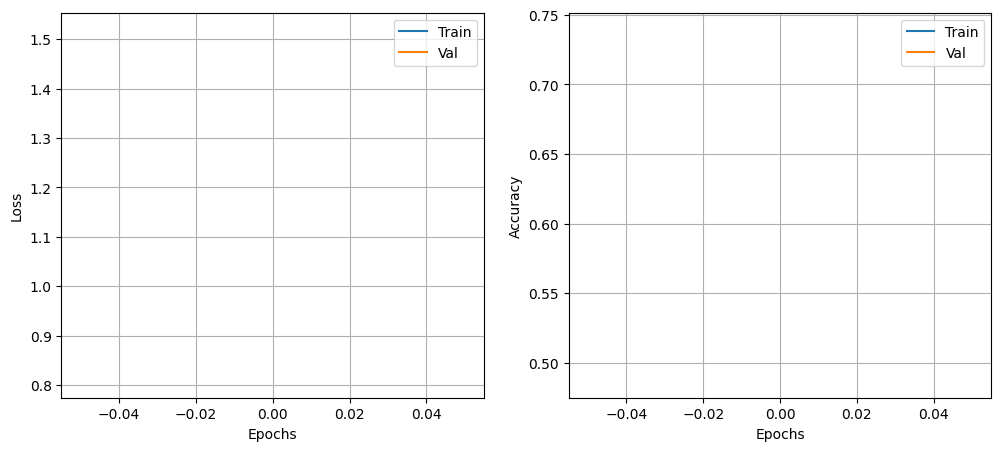

Epoch 2/10
  Train: loss=0.6095 | acc=0.8048
  Val  : loss=0.4621 | acc=0.8602
  Trainable params: 43114


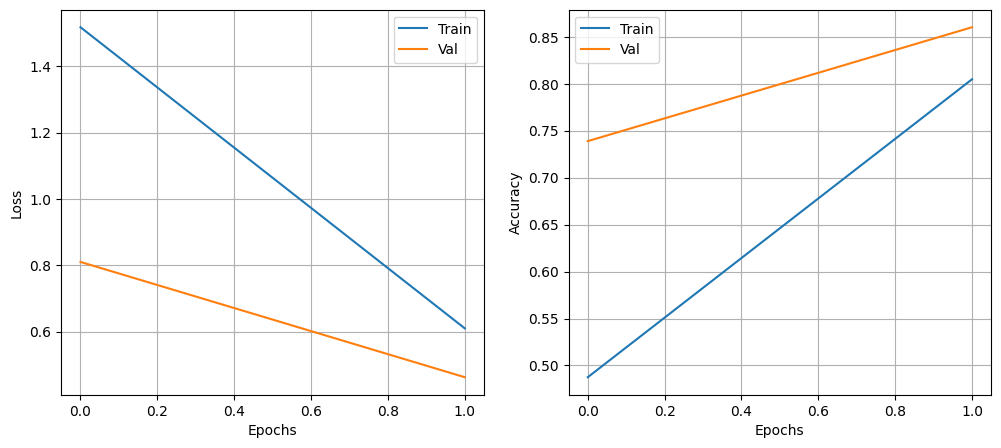

Epoch 3/10
  Train: loss=0.4138 | acc=0.8723
  Val  : loss=0.3439 | acc=0.8967
  Trainable params: 43114


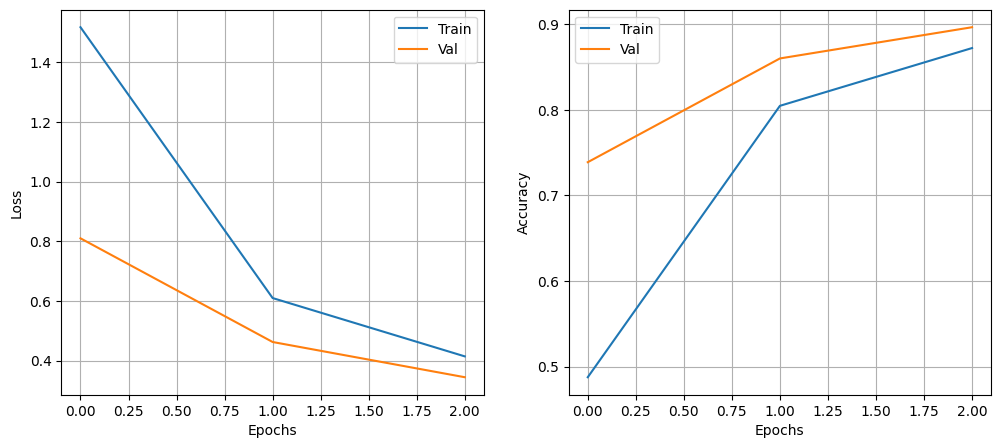

Epoch 4/10
  Train: loss=0.3241 | acc=0.9035
  Val  : loss=0.2799 | acc=0.9152
  Trainable params: 43114


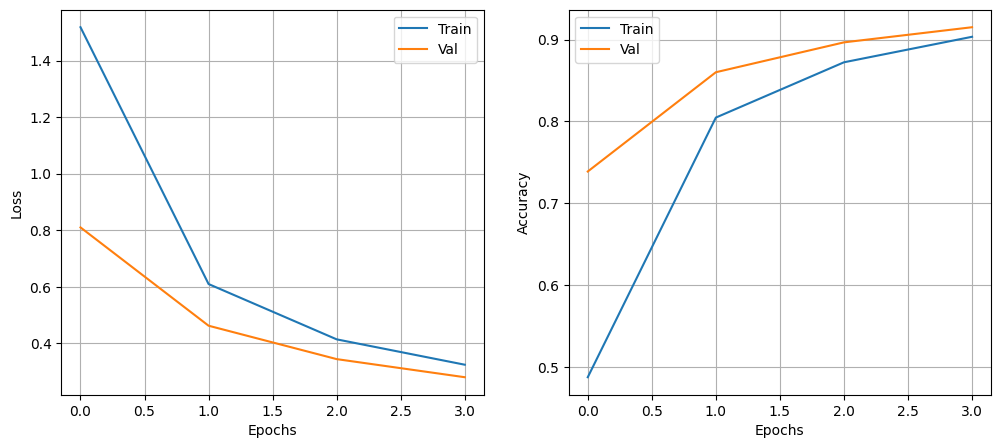

Epoch 5/10
  Train: loss=0.2616 | acc=0.9219
  Val  : loss=0.2353 | acc=0.9277
  Trainable params: 43114


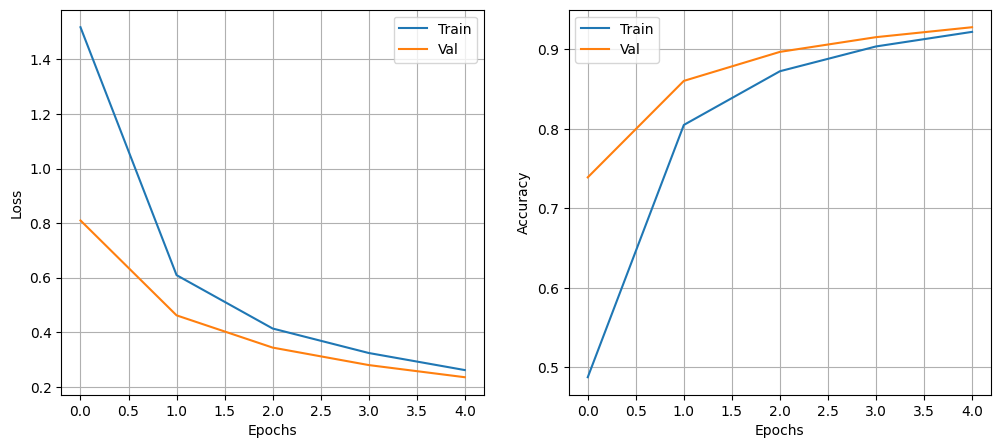

Epoch 6/10
  Train: loss=0.2363 | acc=0.9302
  Val  : loss=0.2049 | acc=0.9397
  Trainable params: 43114


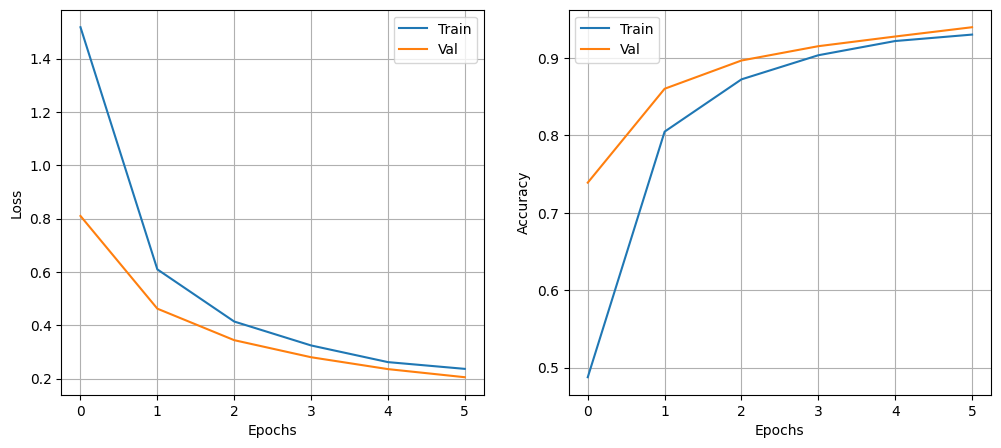

Epoch 7/10
  Train: loss=0.2136 | acc=0.9378
  Val  : loss=0.1872 | acc=0.9435
  Trainable params: 43114


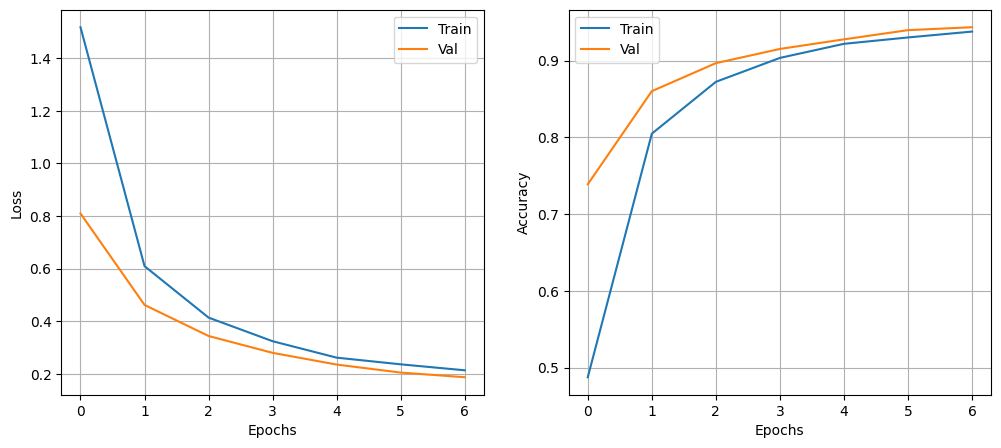

Epoch 8/10
  Train: loss=0.1951 | acc=0.9418
  Val  : loss=0.1712 | acc=0.9508
  Trainable params: 43114


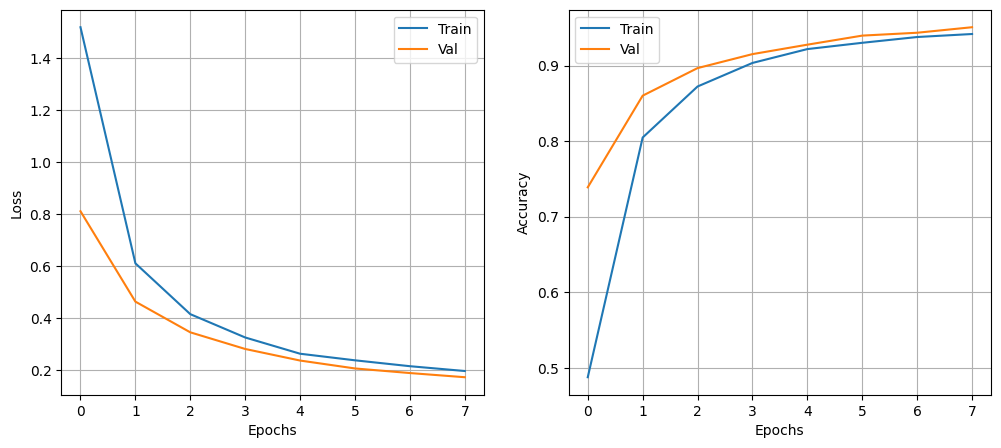

Epoch 9/10
  Train: loss=0.1818 | acc=0.9458
  Val  : loss=0.1649 | acc=0.9499
  Trainable params: 43114


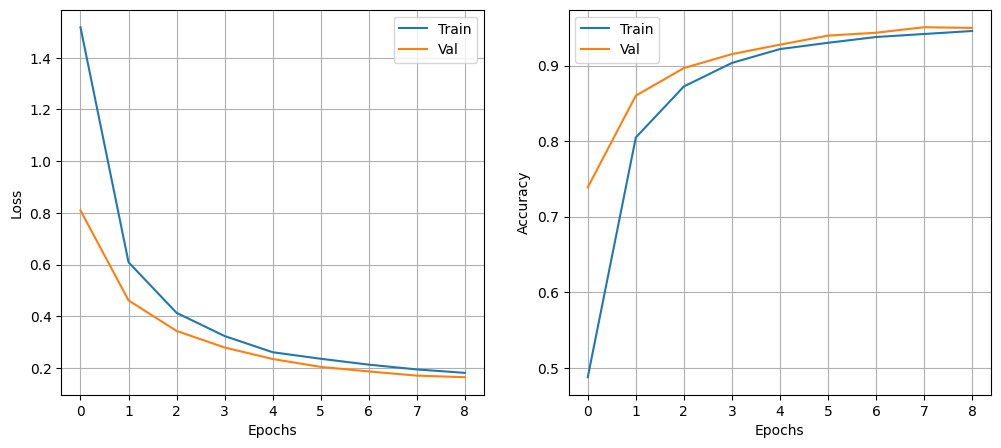

Epoch 10/10
  Train: loss=0.1752 | acc=0.9484
  Val  : loss=0.1571 | acc=0.9534
  Trainable params: 43114


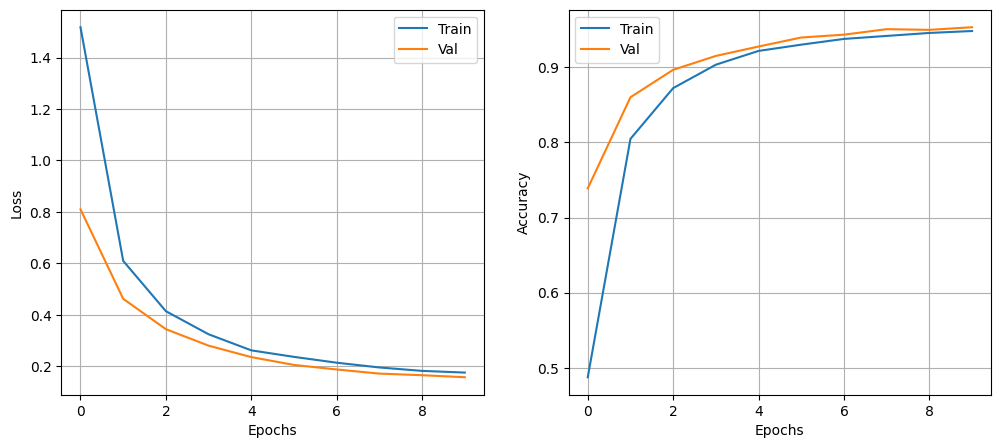

In [25]:
model = TestNetwork(nn.Sequential(*layers))
dropcon_hist = train(net=model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

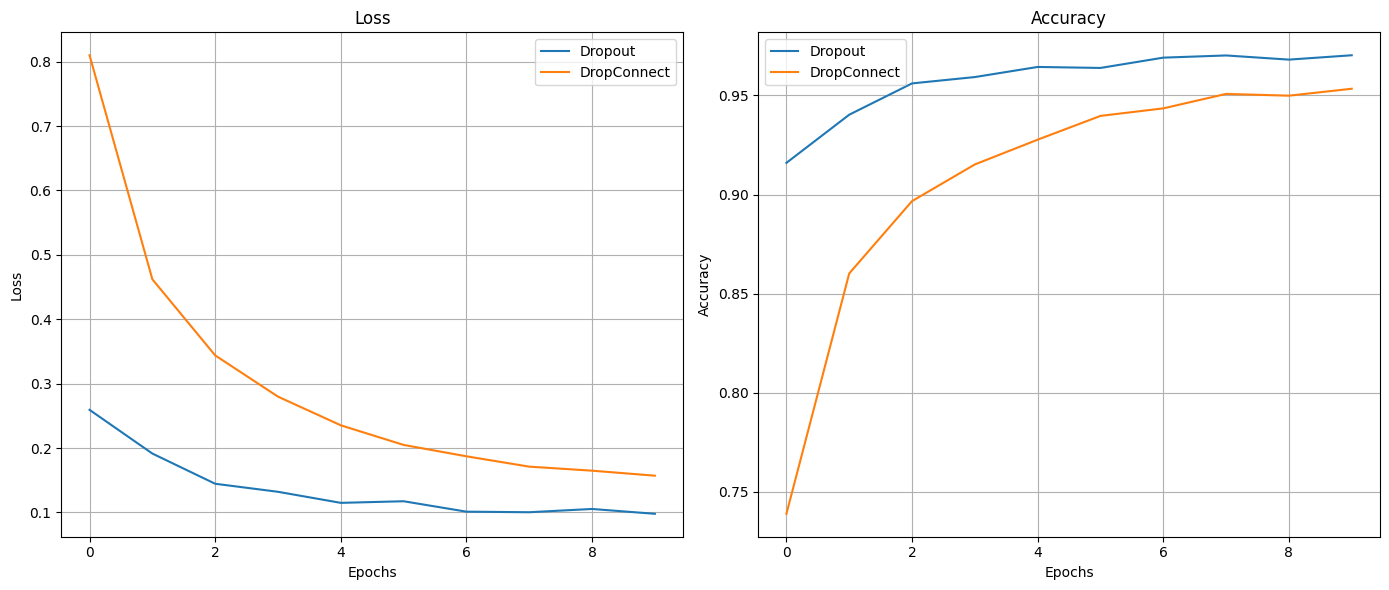

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(dropout_hist["val_loss"],  label="Dropout")
ax1.plot(dropcon_hist["val_loss"], label="DropConnect")
ax1.set_title("Loss"); ax1.set_xlabel("Epochs"); ax1.set_ylabel("Loss"); ax1.legend(); ax1.grid(True)

ax2.plot(dropout_hist["val_acc"],  label="Dropout")
ax2.plot(dropcon_hist["val_acc"], label="DropConnect")
ax2.set_title("Accuracy"); ax2.set_xlabel("Epochs"); ax2.set_ylabel("Accuracy"); ax2.legend(); ax2.grid(True)

plt.tight_layout()
plt.show()

Сравнивая графики для Dropout и DropConnect, можно заметить, что Dropout показывает более быстрое и стабильное снижение потерь, а также более высокую точность на протяжении всего обучения. В то время как DropConnect демонстрирует некоторое отставание в достижении низких потерь и высокой точности. Эти различия могут свидетельствовать о том, что Dropout в данной задаче более эффективно стабилизирует процесс обучения. По итогу, Dropout оказался более эффективным методом для этой задачи.

### Часть 3: Layer Normalization

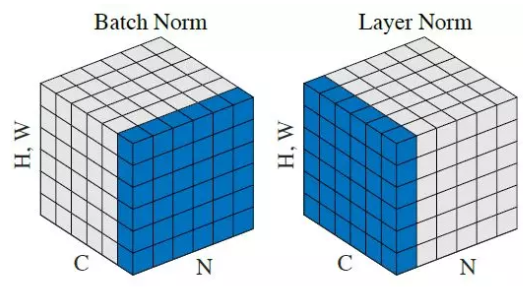

#### 3.1 Реализуйте Layer Normalization **(2 балл)**

In [27]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        output = self.gamma*(x-x.mean())/torch.sqrt(x.std()+1e-8) + self.beta
        return output

#### Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [34]:
# 1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU
layers = [
    nn.Linear(196,128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128,10)
]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.5913 | acc=0.8224
  Val  : loss=0.2302 | acc=0.9276
  Trainable params: 43114


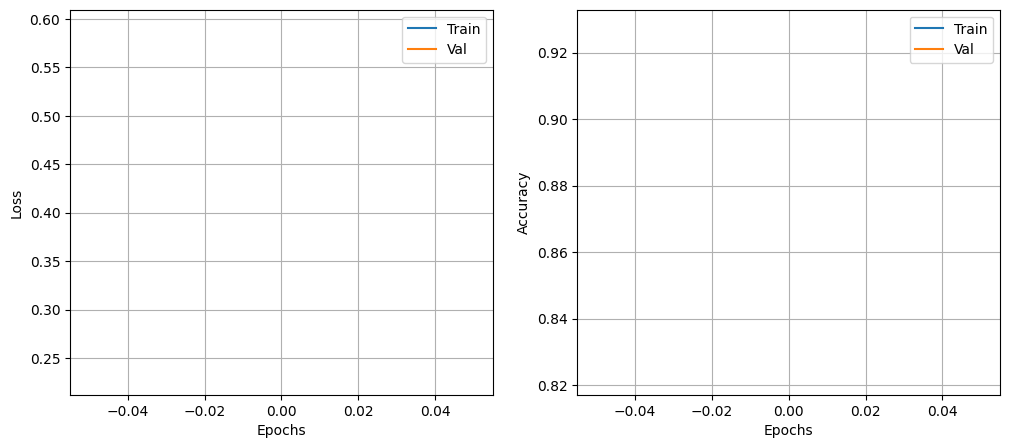

Epoch 2/10
  Train: loss=0.1912 | acc=0.9404
  Val  : loss=0.1597 | acc=0.9511
  Trainable params: 43114


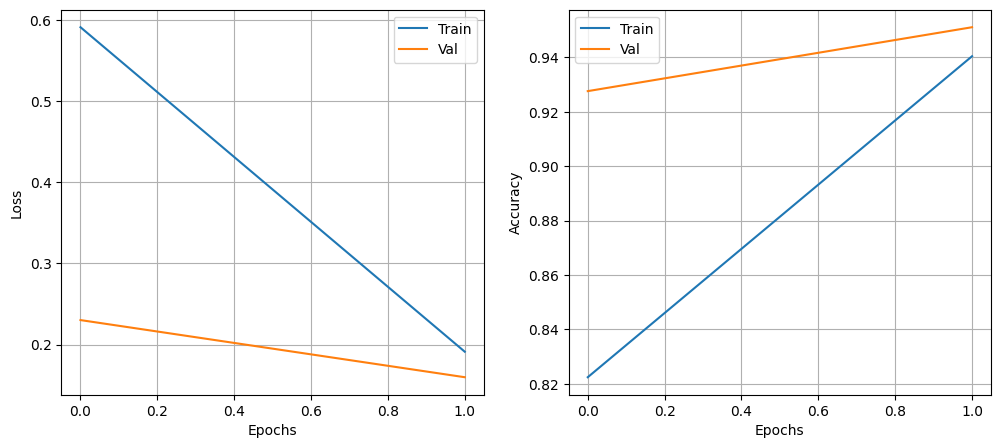

Epoch 3/10
  Train: loss=0.1400 | acc=0.9561
  Val  : loss=0.1322 | acc=0.9562
  Trainable params: 43114


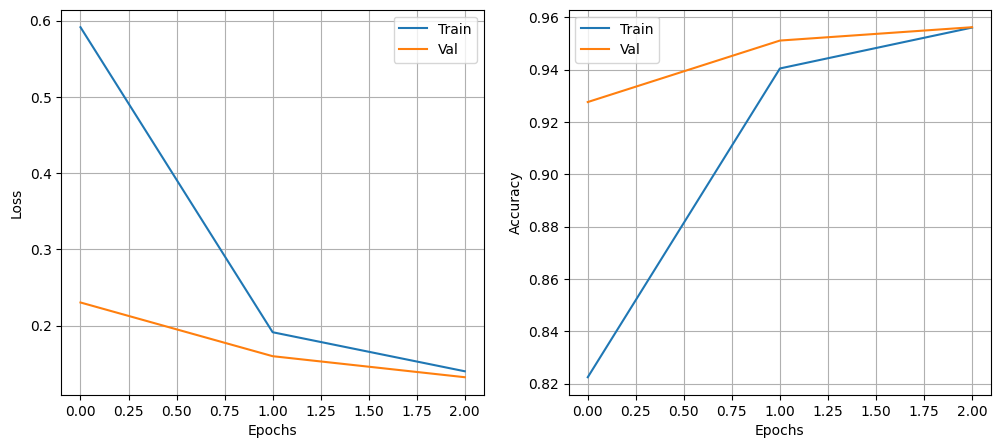

Epoch 4/10
  Train: loss=0.1124 | acc=0.9643
  Val  : loss=0.0953 | acc=0.9674
  Trainable params: 43114


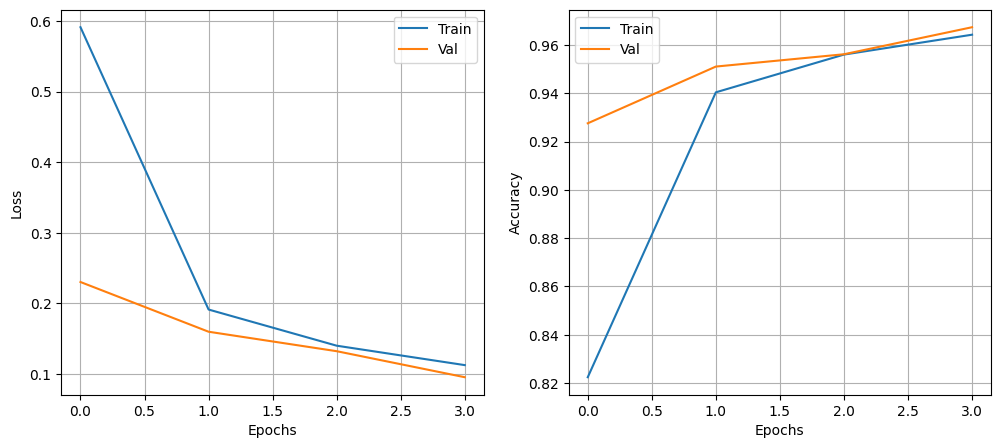

Epoch 5/10
  Train: loss=0.0953 | acc=0.9698
  Val  : loss=0.0954 | acc=0.9684
  Trainable params: 43114


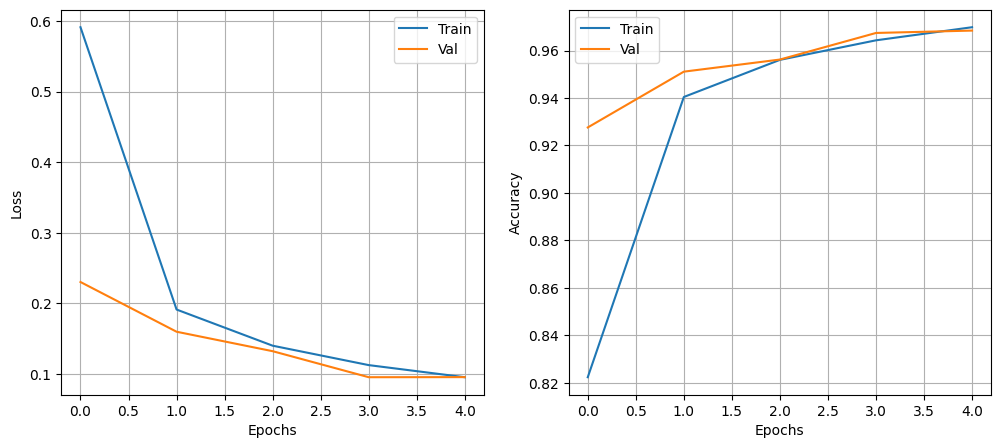

Epoch 6/10
  Train: loss=0.0847 | acc=0.9730
  Val  : loss=0.0861 | acc=0.9702
  Trainable params: 43114


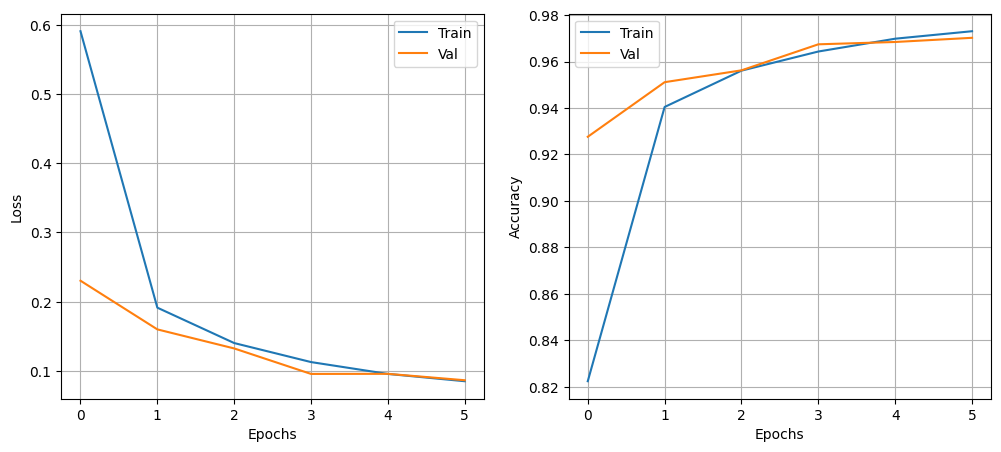

Epoch 7/10
  Train: loss=0.0735 | acc=0.9763
  Val  : loss=0.0711 | acc=0.9746
  Trainable params: 43114


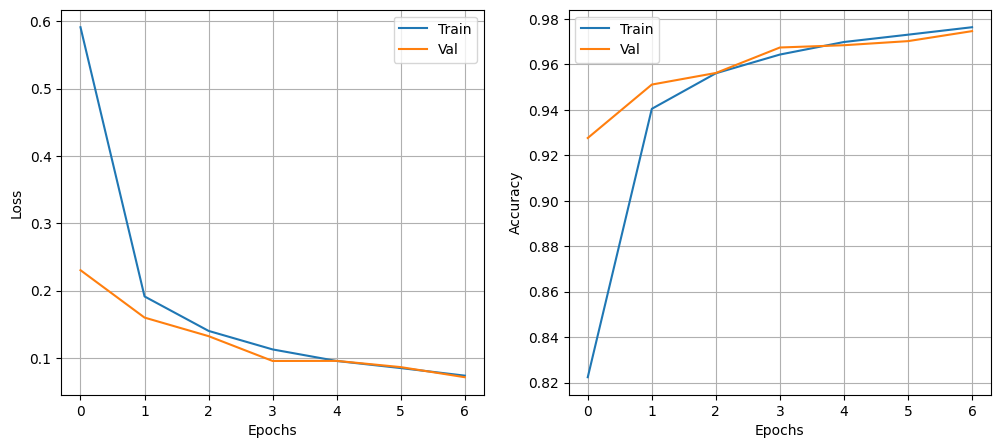

Epoch 8/10
  Train: loss=0.0659 | acc=0.9783
  Val  : loss=0.0714 | acc=0.9761
  Trainable params: 43114


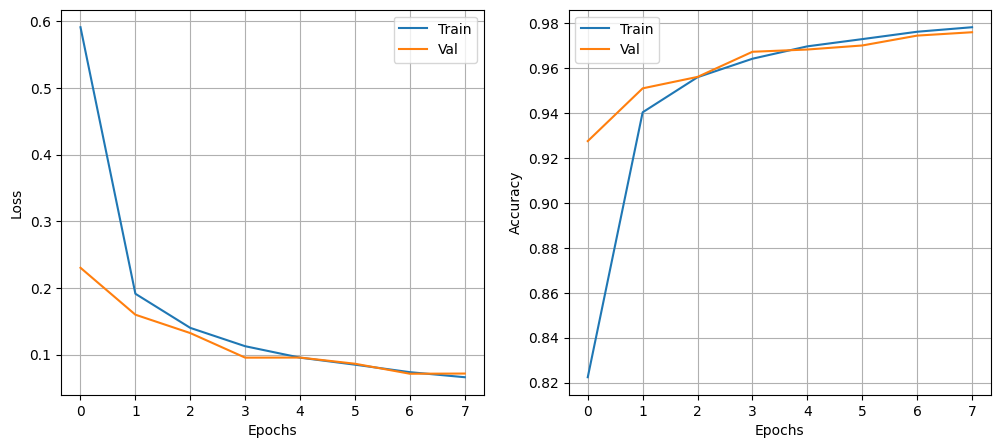

Epoch 9/10
  Train: loss=0.0596 | acc=0.9801
  Val  : loss=0.0859 | acc=0.9714
  Trainable params: 43114


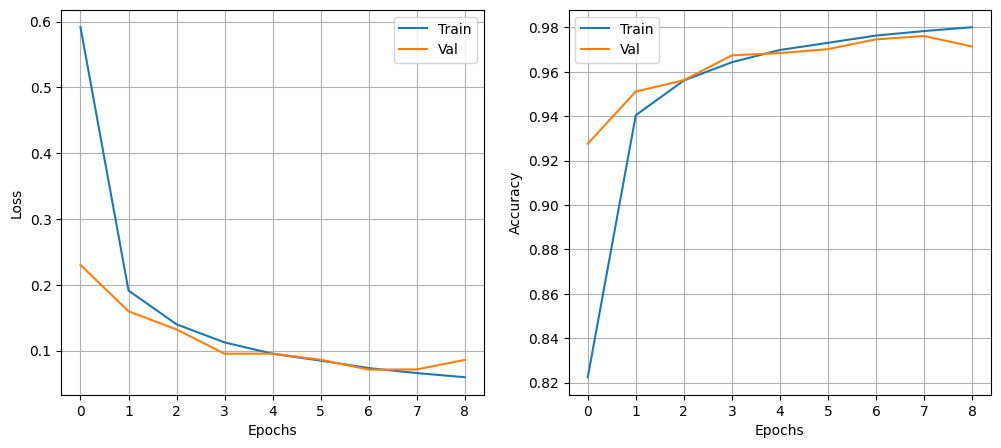

Epoch 10/10
  Train: loss=0.0552 | acc=0.9816
  Val  : loss=0.0668 | acc=0.9775
  Trainable params: 43114


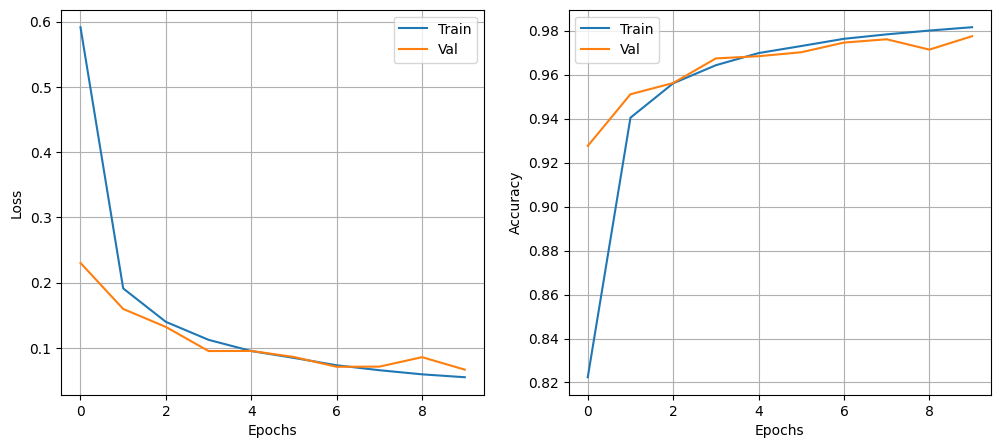

In [35]:
model = TestNetwork(nn.Sequential(*layers))
relu_hist = train(net=model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

In [36]:
# 2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями
layers = [
    nn.Linear(196,128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128,128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128,10)
]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.3945 | acc=0.8960
  Val  : loss=0.1257 | acc=0.9617
  Trainable params: 43626


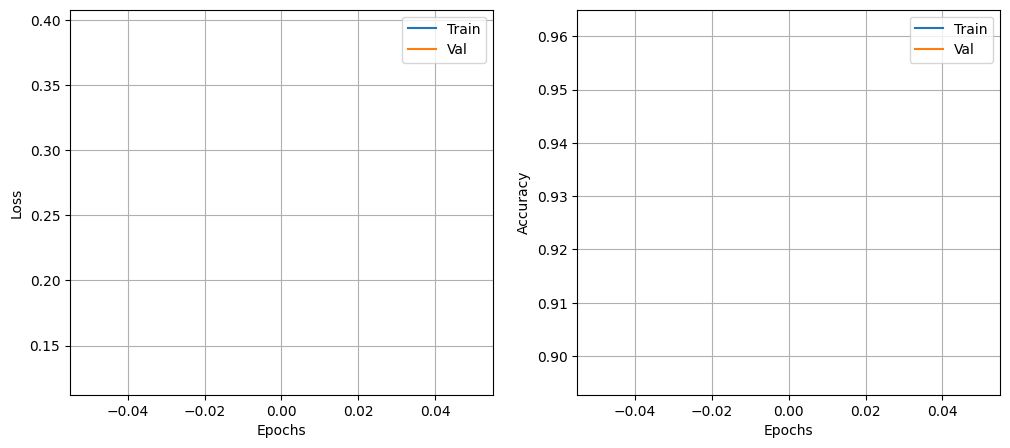

Epoch 2/10
  Train: loss=0.1104 | acc=0.9657
  Val  : loss=0.0799 | acc=0.9725
  Trainable params: 43626


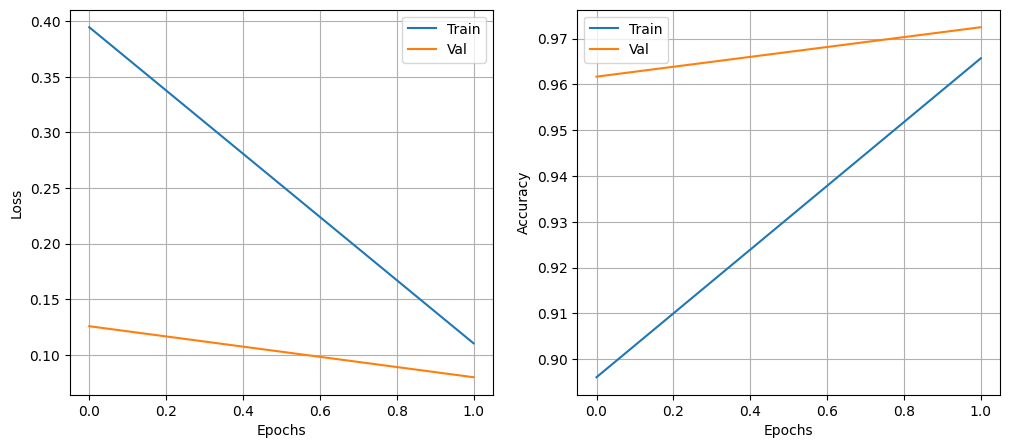

Epoch 3/10
  Train: loss=0.0798 | acc=0.9752
  Val  : loss=0.0727 | acc=0.9751
  Trainable params: 43626


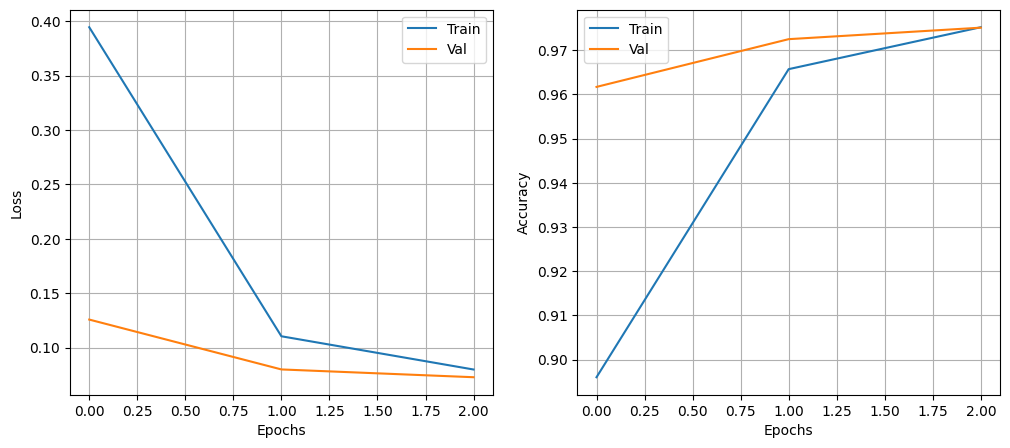

Epoch 4/10
  Train: loss=0.0674 | acc=0.9783
  Val  : loss=0.0857 | acc=0.9708
  Trainable params: 43626


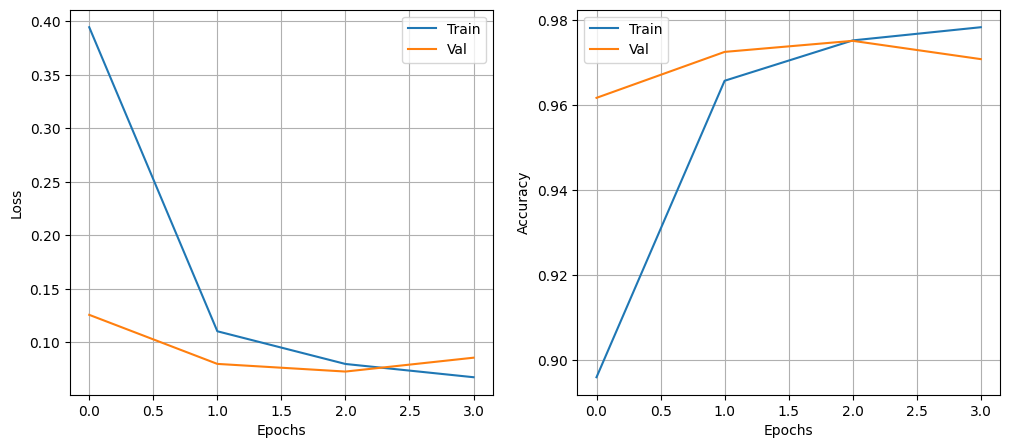

Epoch 5/10
  Train: loss=0.0576 | acc=0.9818
  Val  : loss=0.0558 | acc=0.9813
  Trainable params: 43626


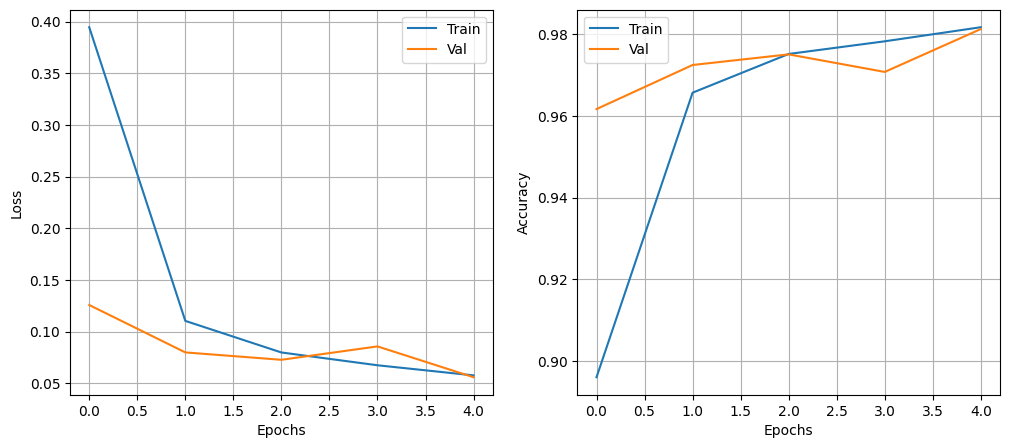

Epoch 6/10
  Train: loss=0.0493 | acc=0.9841
  Val  : loss=0.0621 | acc=0.9778
  Trainable params: 43626


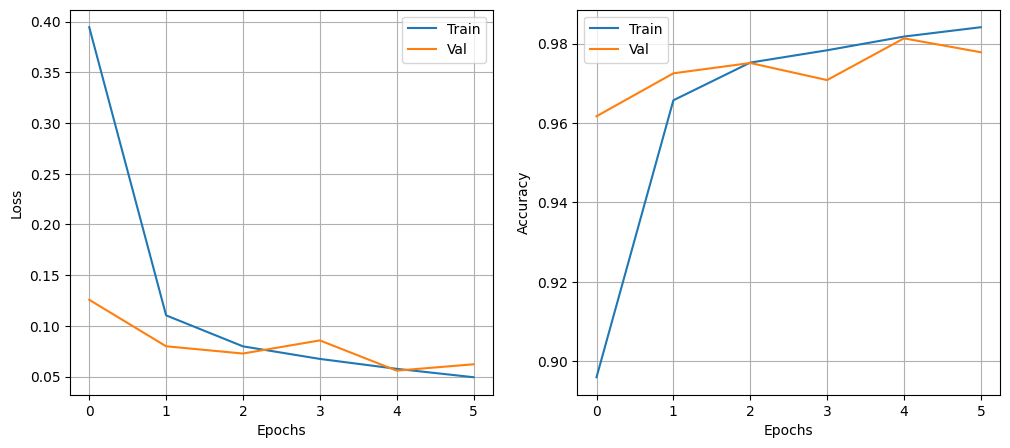

Epoch 7/10
  Train: loss=0.0426 | acc=0.9857
  Val  : loss=0.0503 | acc=0.9833
  Trainable params: 43626


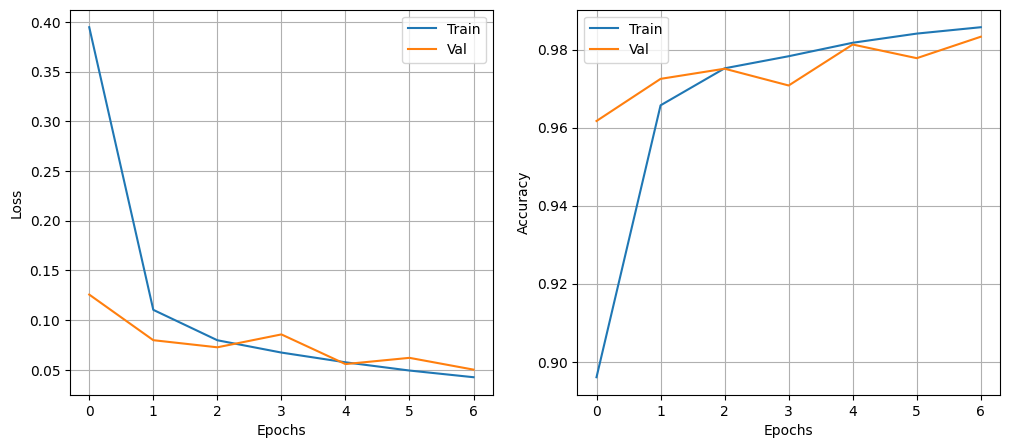

Epoch 8/10
  Train: loss=0.0378 | acc=0.9878
  Val  : loss=0.0518 | acc=0.9837
  Trainable params: 43626


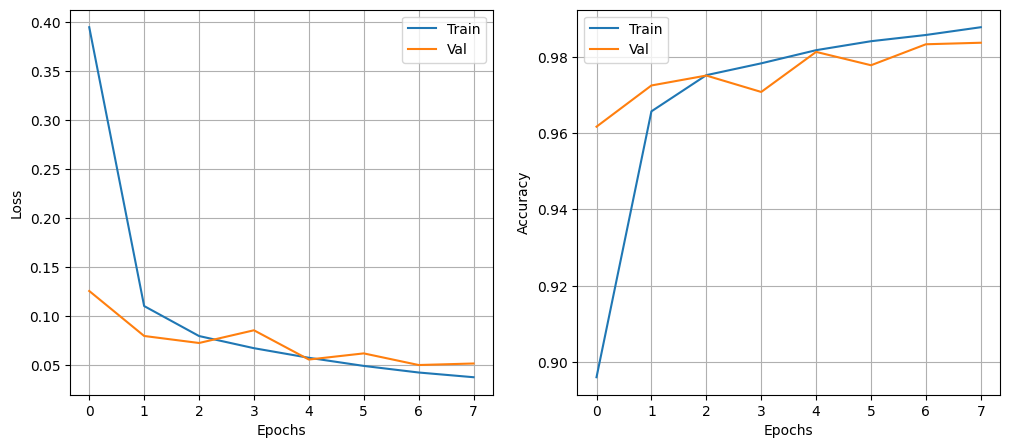

Epoch 9/10
  Train: loss=0.0336 | acc=0.9890
  Val  : loss=0.0486 | acc=0.9846
  Trainable params: 43626


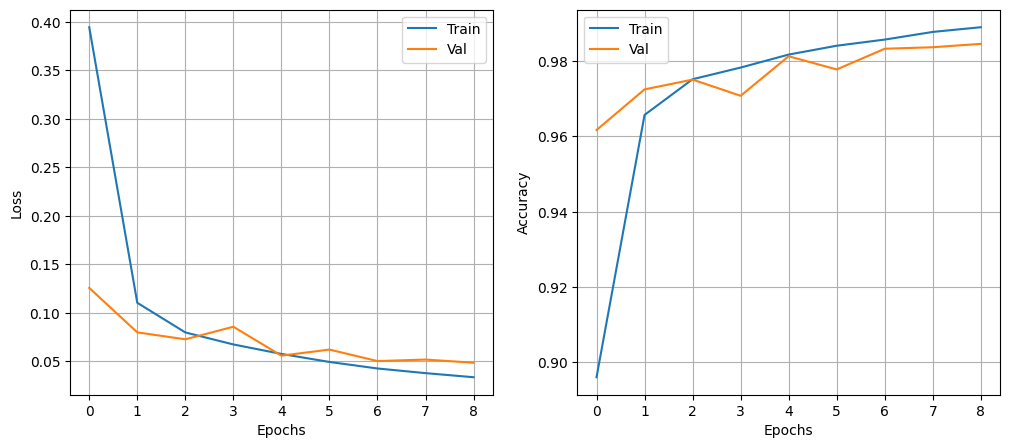

Epoch 10/10
  Train: loss=0.0302 | acc=0.9899
  Val  : loss=0.0568 | acc=0.9837
  Trainable params: 43626


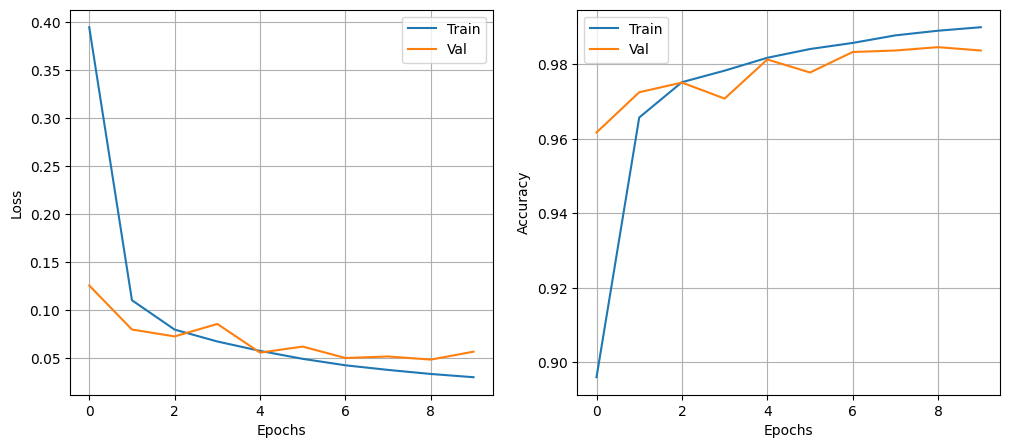

In [37]:
model = TestNetwork(nn.Sequential(*layers))
layerNorm_hist = train(net=model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

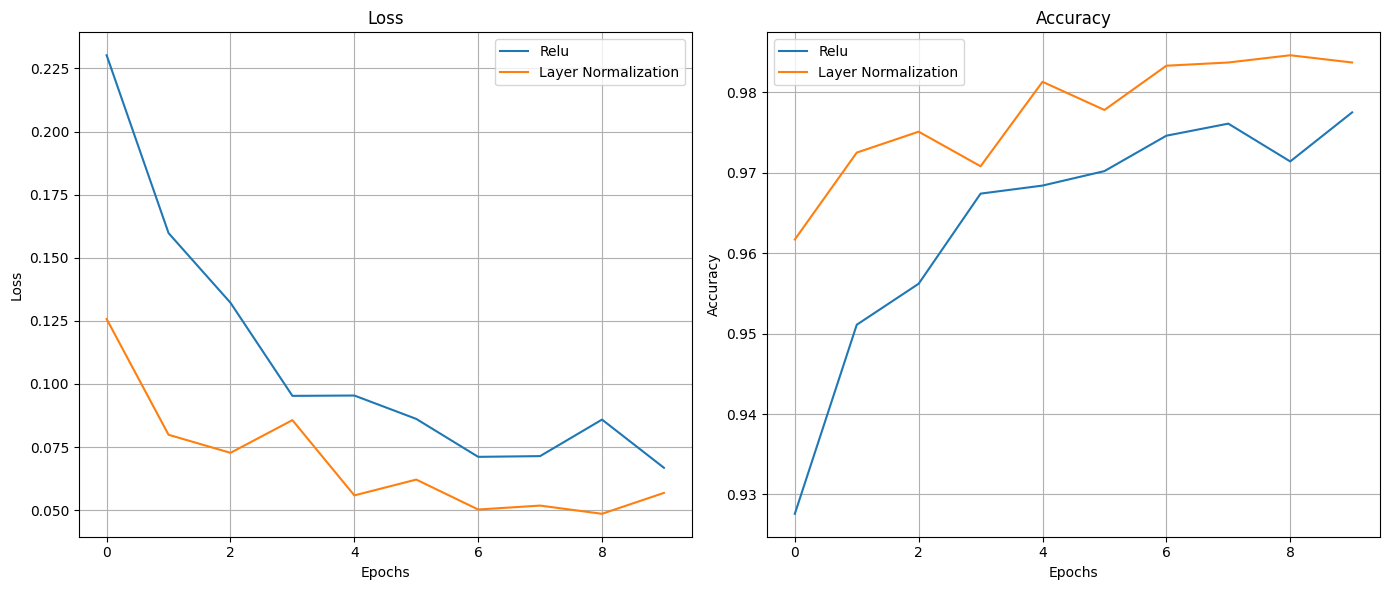

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(relu_hist["val_loss"],  label="Relu")
ax1.plot(layerNorm_hist["val_loss"], label="Layer Normalization")
ax1.set_title("Loss"); ax1.set_xlabel("Epochs"); ax1.set_ylabel("Loss"); ax1.legend(); ax1.grid(True)

ax2.plot(relu_hist["val_acc"],  label="Relu")
ax2.plot(layerNorm_hist["val_acc"], label="Layer Normalization")
ax2.set_title("Accuracy"); ax2.set_xlabel("Epochs"); ax2.set_ylabel("Accuracy"); ax2.legend(); ax2.grid(True)

plt.tight_layout()
plt.show()

На графиках видно, что Layer Normalization значительно улучшает результаты по сравнению с обычным ReLU. На графике потерь Layer Normalization быстрее снижает потери и стабилизируется, достигая низких значений уже в первых эпохах. В то время как ReLU стабилизируется медленнее, показывая более высокие значения потерь. График точности подтверждает, что Layer Normalization позволяет модели быстрее достигать высокой точности и поддерживать этот уровень на протяжении всех эпох, в то время как ReLU стабилизируется позже.